# Instructions

This notebook includes loss plots and surface normal predictions. 
However, in order to run the functions, one will need to have access to the mongodb where the models are saved.
So the commands are not normally runnable, please contact me if in interest of running the training and visualizations.

#  Preparation scripts

Some help functions and prepartions.

In [10]:
import pymongo as pm
import gridfs
import cPickle

conn = pm.MongoClient(port=27022)

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pylab

from scipy import misc
import os
import time

In [5]:
def show_train_learnrate(curr_expid, conn = conn, dbname = 'normalnet-test', colname = 'normalnet.files', start_N = 50, 
                        do_conv = False, conv_len = 100, new_figure = True):
    train_vec = np.concatenate([[(_r['loss'], _r['learning_rate']) for _r in r['train_results']] 
                for r in conn[dbname][colname].find(
                {'exp_id': curr_expid, 'train_results': {'$exists': True}})])
    
    #print(train_vec.shape)
    _N = start_N
    if new_figure:
        fig = plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    inter_list = train_vec[_N:, 0]
    if do_conv:
        conv_list = np.ones([conv_len])/conv_len
        inter_list = np.convolve(inter_list, conv_list, mode='valid')
    plt.plot(inter_list)
    plt.title('Training loss')
    plt.subplot(1, 2, 2)
    plt.plot(train_vec[_N:, 1])
    plt.title('Learning Rate')

In [6]:
vis_big_dict = {}

In [7]:
def show_val(curr_expid, conn = conn, key = 'loss', dbname = 'normalnet-test', colname = 'normalnet.files', new_figure = True):
    test_vec = [r['validation_results']['topn'][key] for r in conn[dbname][colname].find({'exp_id': curr_expid,
                                                                                        'validation_results': {'$exists': True}})]
    _N = 0
    #print(test_vec)
    if new_figure:
        plt.figure()
    plt.plot(test_vec[_N:])
    #plt.gca().set_xscale('log')
    plt.title('Validation Performance')    

In [8]:
def show_status(curr_expid, conn = conn, new_figure = True, dbname = 'normalnet-test', colname = 'normalnet.files', key = 'loss'):
    show_train_learnrate(curr_expid, conn = conn, do_conv=True, new_figure = new_figure, dbname = dbname, colname = colname)
    show_val(curr_expid, conn = conn, new_figure = new_figure, dbname = dbname, colname = colname, key = key)

In [14]:
def show_result_from_mongodb(exp_id_now, indx_rec, which_save = 0, which_exam = 0, 
                             dbname = 'normalnet-test', colname = 'normalnet.files', gridfs_name = 'normalnet', 
                             conn = conn, cache_flag = False, big_dict = vis_big_dict, 
                             inv_norm = False, 
                             vis_key_list = ['outputs_fea', 'normals_fea', 'images_fea'],
                            ):
    r = conn[dbname][colname].find({'exp_id': exp_id_now, 'validation_results': {'$exists': True}})
    idval = r[indx_rec]['_id']
    coll = conn[dbname][colname]
    fn = coll.find({'item_for': idval})[0]['filename']

    if fn in big_dict:
        saved_data = big_dict[fn]
    else:
        fs = gridfs.GridFS(coll.database, gridfs_name)
        fh = fs.get_last_version(fn)
        saved_data = cPickle.loads(fh.read())
        fh.close()

        if cache_flag:
            big_dict[fn] = saved_data
    
    output_now = saved_data['validation_results']['feats'][vis_key_list[0]][which_save][which_exam]
    normal_now = saved_data['validation_results']['feats'][vis_key_list[1]][which_save][which_exam]
    image_now = saved_data['validation_results']['feats'][vis_key_list[2]][which_save][which_exam]
    
    if normal_now.shape[2]==1:
        normal_now = normal_now.reshape(normal_now.shape[:2])
    
    
    if image_now.shape[2]==1:
        image_now = image_now.reshape(image_now.shape[:2])
    
    
    #print(output_now.shape)
    #print(np.min(normal_now))
    
    if inv_norm:
        orig_norm = np.linalg.norm(normal_now, axis = 2)
        new_norm = np.linalg.norm(output_now, axis = 2)
        for im_indx1 in xrange(output_now.shape[0]):
            for im_indx2 in xrange(output_now.shape[1]):
                output_now[im_indx1][im_indx2] = output_now[im_indx1][im_indx2]/new_norm[im_indx1][im_indx2]*orig_norm[im_indx1][im_indx2]                

    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(output_now)
    ax1.axis('off')
    ax2.imshow(normal_now)
    ax2.axis('off')
    ax3.imshow(image_now)
    plt.gcf().set_size_inches(10.5, 4.5)
    ax3.axis('off')

# Loss v.s. training steps

The plots shown below are for the experiment and network including training loss v.s. training batches, learning rate v.s. training batches, and validation performance v.s. epoches.

The training loss is inverse dot product loss of range (-1, 1). 
The lower of the loss, the better.
The training loss shown in the plot is the average of 200 loss values around the center point to make the plot clear.

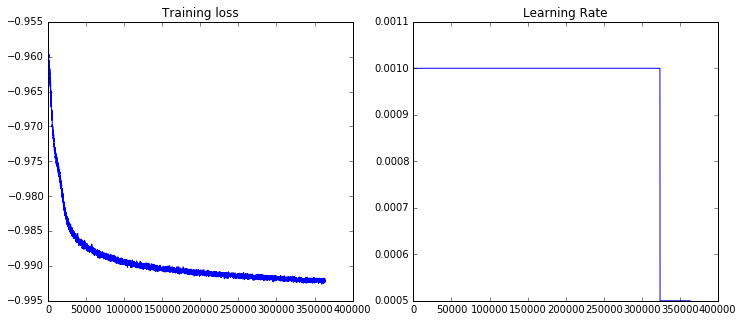

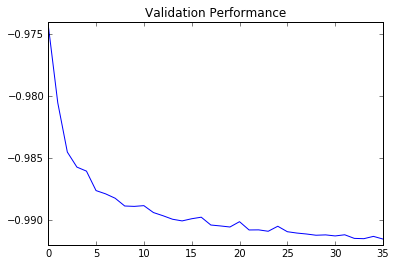

In [12]:
curr_expid = 'rms_momopt'
show_status(curr_expid, key = 'loss_2')

# Predictions for surface normals

The predictions of models at different timestamps are shown below from the begining of training to the end of training.

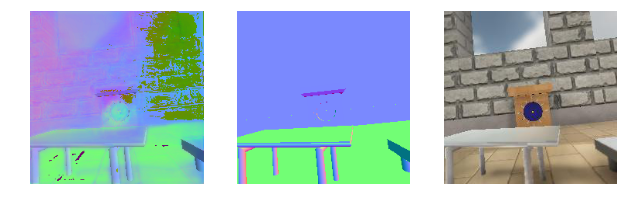

In [25]:
# Output of first epoch
show_result_from_mongodb(curr_expid, 0, 1, 3, cache_flag=True, inv_norm=True)

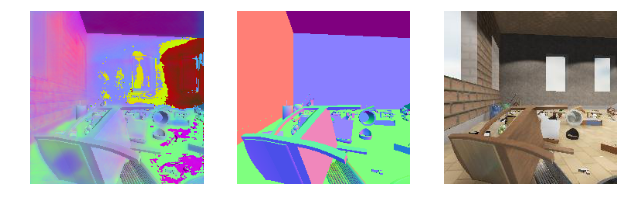

In [16]:
# Output of second epoch
show_result_from_mongodb(curr_expid, 1, 3, 3, cache_flag=True, inv_norm=True)

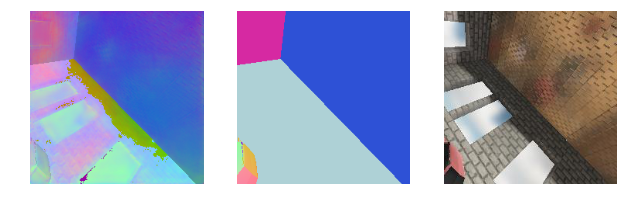

In [17]:
# Output of third epoch
show_result_from_mongodb(curr_expid, 2, 3, 3, cache_flag=True, inv_norm=True)

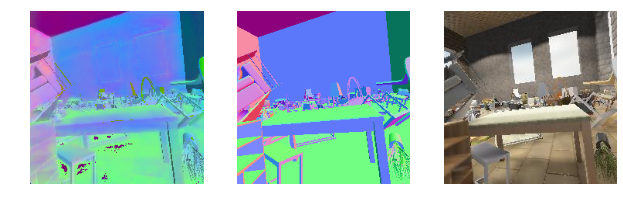

In [18]:
# Output of fifth epoch
show_result_from_mongodb(curr_expid, 4, 3, 3, cache_flag=True, inv_norm=True)

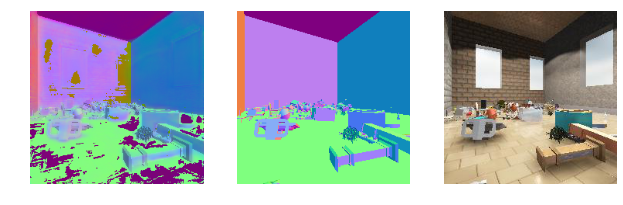

In [19]:
# Output of 9th epoch

show_result_from_mongodb(curr_expid, 8, 3, 3, cache_flag=True, inv_norm=True)

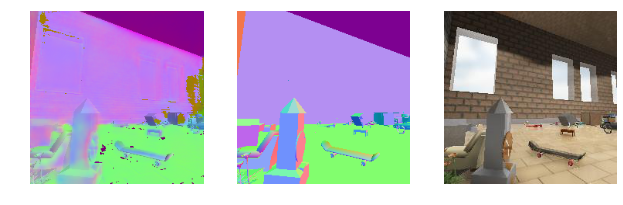

In [20]:
# Output of 17th epoch

show_result_from_mongodb(curr_expid, 16, 3, 3, cache_flag=True, inv_norm=True)

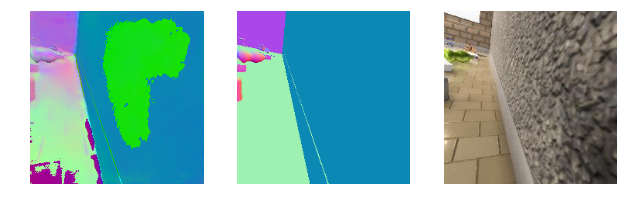

In [21]:
# Output of 35th epoch

show_result_from_mongodb(curr_expid, 34, 3, 3, cache_flag=True, inv_norm=True)

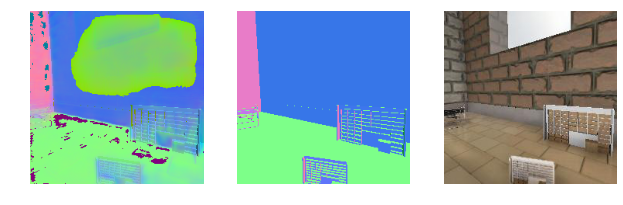

In [22]:
# Output of 35th epoch

show_result_from_mongodb(curr_expid, 34, 0, 3, cache_flag=True, inv_norm=True)

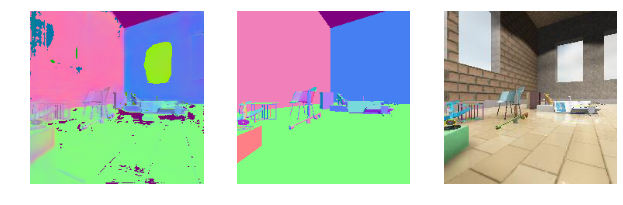

In [23]:
# Output of 35th epoch

show_result_from_mongodb(curr_expid, 34, 1, 3, cache_flag=True, inv_norm=True)

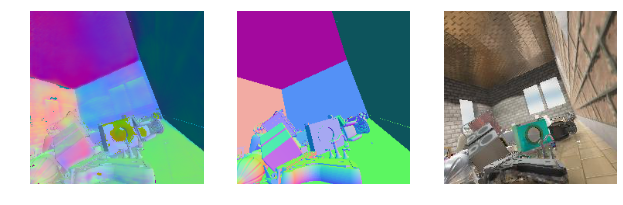

In [24]:
# Output of 35th epoch

show_result_from_mongodb(curr_expid, 34, 2, 3, cache_flag=True, inv_norm=True)